<a href="https://colab.research.google.com/github/Harshilpatel2605/Fruit-Ripeness-Classifier/blob/main/fruit_ripeness_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ignore python warnings
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # ignore tensorflow logs


In [ ]:
# ========================================
# Step 1: Install dependencies
# ========================================
!pip install -q kaggle
!pip install -q tensorflow

In [ ]:
# ========================================
# Step 2: Mount Google Drive for optional Kaggle API
# ========================================

# Make sure the .kaggle directory exists in the home folder
os.makedirs('/root/.kaggle', exist_ok=True)

# Copy your kaggle.json from your custom folder to the .kaggle folder
!cp /content/kaggle/kaggle.json ~/.kaggle/

# Set correct permissions
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# ========================================
# Step 3: Set dataset & model paths
# ========================================
DATASET_PATH = '/content/dataset'
MODEL_PATH = '/content/fruit_ripeness_model.h5'

In [ ]:

# ========================================
# Step 4: Download & unzip dataset (if not exists)
# ========================================
if not os.path.exists(DATASET_PATH):
    print("Downloading dataset...")
    !kaggle datasets download -d leftin/fruit-ripeness-unripe-ripe-and-rotten -q
    !unzip -q -o fruit-ripeness-unripe-ripe-and-rotten.zip -d {DATASET_PATH}
else:
    print("Dataset already exists, skipping download.")


Dataset already exists, skipping download.


In [ ]:
# ========================================
# Step 5: Setup GPU strategy
# ========================================
import tensorflow as tf

strategy = tf.distribute.get_strategy()  # Automatically uses GPU if available
print("Using default strategy (GPU/CPU if available)")
print("REPLICAS: ", strategy.num_replicas_in_sync)

Using default strategy (GPU/CPU if available)
REPLICAS:  1


Ordered Classes: ['unripe apple', 'unripe banana', 'unripe orange', 'freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']


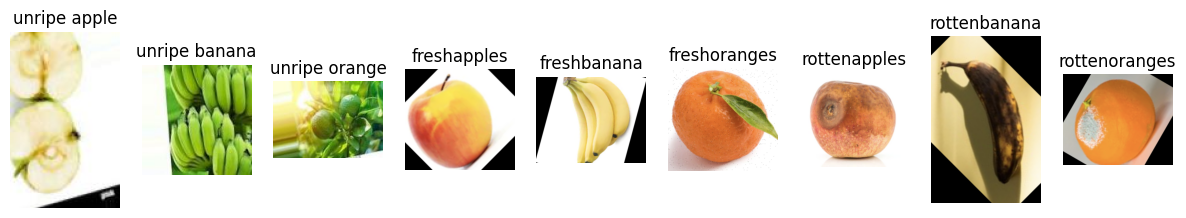

In [ ]:
# ========================================
# Step 6: Prepare Data & Class Order
# ========================================
from tensorflow.keras.preprocessing import image_dataset_from_directory

IMG_SIZE = (100,100)
BATCH_SIZE = 128
DATASET_TRAIN_PATH = os.path.join(DATASET_PATH, 'fruit_ripeness_dataset/archive (1)/dataset')

# Get classes and reorder
train_path = os.path.join(DATASET_TRAIN_PATH, 'train')
all_classes = [cls for cls in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, cls))]
desired_order = ['unripe apple', 'unripe banana', 'unripe orange',
                 'freshapples', 'freshbanana', 'freshoranges',
                 'rottenapples', 'rottenbanana', 'rottenoranges']
classes = [cls for cls in desired_order if cls in all_classes]
print("Ordered Classes:", classes)

# Display one sample image per class
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

plt.figure(figsize=(15,5))
for i, cls in enumerate(classes):
    cls_path = os.path.join(train_path, cls)
    img_files = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]
    img_file = random.choice(img_files)
    img_path = os.path.join(cls_path, img_file)
    img = mpimg.imread(img_path)
    plt.subplot(1, len(classes), i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
plt.show()

In [ ]:
# ========================================
# Step 7: Train or Load saved model
# ========================================
from tensorflow.keras.models import load_model
import shutil

# Paths
RAW_TRAIN_PATH = '/content/dataset/fruit_ripeness_dataset/archive (1)/dataset/train'
CLEAN_TRAIN_PATH = '/content/dataset/clean_train'
MODEL_PATH = '/content/fruit_ripeness_model.h5'

# Desired class order
classes = ['unripe apple', 'unripe banana', 'unripe orange',
           'freshapples', 'freshbanana', 'freshoranges',
           'rottenapples', 'rottenbanana', 'rottenoranges']

# Clean dataset: copy only required classes and ignore duplicates
os.makedirs(CLEAN_TRAIN_PATH, exist_ok=True)
for cls in classes:
    src = os.path.join(RAW_TRAIN_PATH, cls)
    dst = os.path.join(CLEAN_TRAIN_PATH, cls)
    if os.path.exists(src):
        shutil.copytree(src, dst, dirs_exist_ok=True)

# Check if training is needed
train_needed = not os.path.exists(MODEL_PATH)

if train_needed:
    print("No saved model found. Preparing datasets and training...")

    # Prepare datasets
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        CLEAN_TRAIN_PATH,
        validation_split=0.2,
        subset="training",
        seed=42,
        image_size=(100,100),
        batch_size=128,
        class_names=classes
    )

    val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        CLEAN_TRAIN_PATH,
        validation_split=0.2,
        subset="validation",
        seed=42,
        image_size=(100,100),
        batch_size=128,
        class_names=classes
    )

    # Normalize
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
    val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

    # Build CNN inside strategy.scope
    with strategy.scope():
        model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100,100,3)),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(len(classes), activation='softmax')
        ])

        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

    model.summary()

    # Train model
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=15
    )

    # Save model
    model.save(MODEL_PATH)
    print("Model trained and saved!")

else:
    print("Saved model found! Loading model...")
    model = load_model(MODEL_PATH)
    history = None  # dummy for plotting if needed



No saved model found. Preparing datasets and training...
Found 16217 files belonging to 9 classes.
Using 12974 files for training.
Found 16217 files belonging to 9 classes.
Using 3243 files for validation.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,732,937 (6.61 MB)

 Trainable params: 1,732,937 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 32s 277ms/step - accuracy: 0.4768 - loss: 1.3704 - val_accuracy: 0.7360 - val_loss: 0.6524
Epoch 2/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.7579 - loss: 0.6028 - val_accuracy: 0.7811 - val_loss: 0.5225
Epoch 3/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 264ms/step - accuracy: 0.7993 - loss: 0.4861 - val_accuracy: 0.7764 - val_loss: 0.5169
Epoch 4/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.8299 - loss: 0.4094 - val_accuracy: 0.8366 - val_loss: 0.3924
Epoch 5/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.8668 - loss: 0.3302 - val_accuracy: 0.8418 - val_loss: 0.3904
Epoch 6/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 41s 268ms/step - accuracy: 0.8865 - loss: 0.2801 - val_accuracy: 0.8249 - val_loss: 0.4524
Epoch 7/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.8922 - loss: 0.2675 - val_accuracy: 0.8532 - val_loss: 0.3939
Epoch 8/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 40s 264ms/step - accuracy: 0.9294 - loss: 0

Model trained and saved!


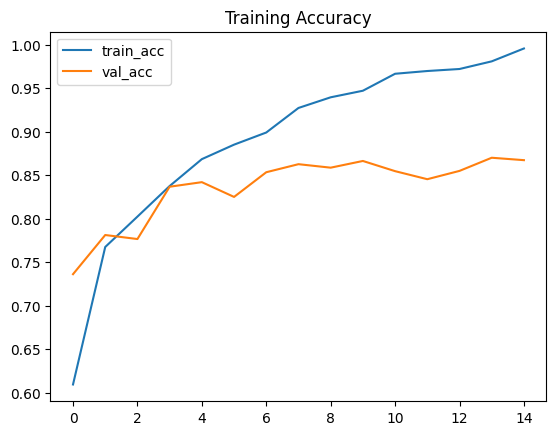

In [ ]:
# ========================================
# Step 8: Plot Accuracy Graph (trained or loaded)
# ========================================
import matplotlib.pyplot as plt
import numpy as np

if train_needed:
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.title("Training Accuracy")
    plt.legend()
    plt.show()
else:
    # If model loaded, evaluate on validation set to plot accuracy
    val_dataset_eval = image_dataset_from_directory(
        DATASET_TRAIN_PATH,
        validation_split=0.2,
        subset="validation",
        seed=42,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_names=classes
    )
    val_dataset_eval = val_dataset_eval.map(lambda x, y: (x/255.0, y))
    loss, acc = model.evaluate(val_dataset_eval)
    print(f"Validation Accuracy: {acc*100:.2f}%")
    plt.bar(['Validation Accuracy'], [acc])
    plt.ylim(0,1)
    plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


<Figure size 1000x1000 with 0 Axes>

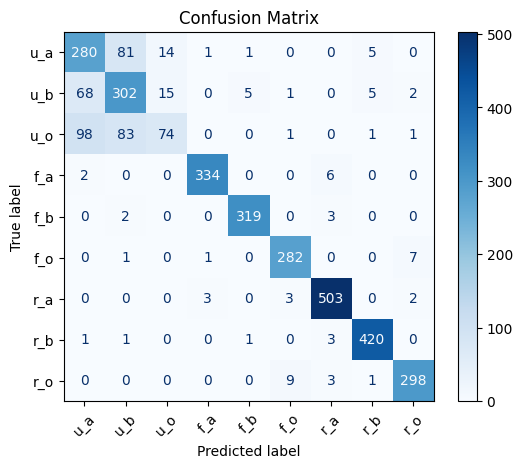

In [ ]:

# ========================================
# Step 9: Confusion Matrix
# ========================================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Short class names
short_classes = [
    'u_a', 'u_b', 'u_o',   # unripe apple, banana, orange
    'f_a', 'f_b', 'f_o',   # fresh apple, banana, orange
    'r_a', 'r_b', 'r_o'    # rotten apple, banana, orange
]

# Generate predictions
y_true = []
y_pred = []

for images, labels in val_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(preds.argmax(axis=1))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=short_classes)
plt.figure(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues, values_format='d', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

